In [ ]:
from typing import Literal

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.ops as ops
from tqdm import tqdm

from src.data_modules.detection_data_module import CbisDdsmDataModuleDetection
from src.models.detection_model import DetectionModel

### Load Data and Model


In [ ]:
BATCH_SIZE = 5

datamodule = CbisDdsmDataModuleDetection(
    root_dir="data/cbis-ddsm-detec",
    tumor_type="mass",
    batch_size=BATCH_SIZE,
    num_workers=4,
)

In [ ]:
model = DetectionModel(weight_path="models/mass-detection.ckpt")
model = model.eval()

Loaded weights from models/mass-detection.ckpt


## Model evaluation

### Define evaluation metrics

Define core evaluation functions:

- **IoU (Intersection over Union):** measures overlap between predicted and ground-truth boxes.
- **Precision:** how many predicted positives are correct (TP / (TP + FP)).
- **Recall:** how many actual positives are detected (TP / (TP + FN)).
- **F1 Score:** harmonic mean of precision and recall, balancing both.


In [ ]:
def calculate_iou(boxA, boxB):
    # box: [xmin, ymin, xmax, ymax]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)


def calculate_metrics(ground_truth_boxes, predicted_boxes, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    matched_ground_truth = set()
    iou_sum = 0

    for pred in predicted_boxes:
        best_iou = 0
        best_ground_truth_idx = -1
        for idx, ground_truth in enumerate(ground_truth_boxes):
            iou = calculate_iou(pred, ground_truth)
            if iou > best_iou:
                best_iou = iou
                best_ground_truth_idx = idx
        if (
            best_iou >= iou_threshold
            and best_ground_truth_idx not in matched_ground_truth
        ):
            true_positives += 1
            matched_ground_truth.add(best_ground_truth_idx)
            iou_sum += best_iou
        else:
            false_positives += 1

    false_negatives = len(ground_truth_boxes) - len(matched_ground_truth)
    return true_positives, false_positives, false_negatives, iou_sum


def precision(true_positives, false_positives):
    if true_positives + false_positives == 0:
        return 1 if true_positives == 0 else 0
    return true_positives / (true_positives + false_positives)


def recall(true_positives, false_negatives):
    if true_positives + false_negatives == 0:
        return 1 if true_positives == 0 else 0
    return true_positives / (true_positives + false_negatives)


def f1_score(true_positives, false_positives, false_negatives):
    p = precision(true_positives, false_positives)
    r = recall(true_positives, false_negatives)
    if p + r == 0:
        return 0
    return 2 * (p * r) / (p + r)

### Evaluate model

Define a function to run evaluation across the validation set:

- Apply the model to each batch.
- Filter predictions based on confidence and Non-Maximum Suppression (NMS).
- Match predictions to ground-truth boxes based on IoU threshold.
- Aggregate true positives, false positives, false negatives, and IoU statistics.

We computed the mean IoU across all cases, assigning an IoU of 0 for missed detections (false negatives).  
Additionally, we calculated the mean IoU considering only the true positives, where the model correctly detected the ground-truth tumor.


In [ ]:
def evaluate_model(
    model, val_dataloader, confidence_threshold, iou_threshold, quiet=False
):
    total_tp, total_fp, total_fn, total_iou_sum = 0, 0, 0, 0

    for batch in tqdm(val_dataloader, desc="Evaluating", disable=quiet):
        xs, ys = batch[0], batch[1]

        model.eval()
        with torch.no_grad():
            pred = model(xs)

        for i in range(len(xs)):
            scores = pred[i]["scores"]
            boxes = pred[i]["boxes"]
            gt_boxes = ys[i]["boxes"]
            predicted_boxes = boxes[scores > confidence_threshold]
            keep_indices = ops.nms(
                predicted_boxes,
                scores[scores > confidence_threshold],
                iou_threshold,
            )
            # Filtered results
            filtered_boxes = predicted_boxes[keep_indices]

            tp, fp, fn, iou_sum = calculate_metrics(
                gt_boxes.cpu().numpy(),
                filtered_boxes.cpu().numpy(),
                iou_threshold=iou_threshold,
            )
            total_tp += tp
            total_fp += fp
            total_fn += fn
            total_iou_sum += iou_sum

    total_number = total_tp + total_fp + total_fn
    mean_iou_tp = total_iou_sum / total_tp if total_tp > 0 else 0
    mean_iou_all = total_iou_sum / total_number if total_number > 0 else 0

    if not quiet:
        print(f"True Positives: {total_tp}")
        print(f"False Positives: {total_fp}")
        print(f"False Negatives: {total_fn}")
        print(f"Mean IoU: {mean_iou_all:.4f}")
        print(f"Mean IoU (TP): {mean_iou_tp:.4f}")

    return total_tp, total_fp, total_fn, mean_iou_all, mean_iou_tp

## Threshold Analysis

Analyze how model performance changes across different thresholds:

- For confidence thresholds: observe how changing minimum score affects detection quality.
- For IoU thresholds: observe how stricter matching criteria affect precision and recall.

Plots:

- **Precision-Recall Curve**: visualizes the trade-off between precision and recall.
- **F1 Score Trend**: shows how F1 score evolves with the threshold.


In [ ]:
def threshold_analysis(model, threshold_name: Literal["confidence", "iou"], thresholds):
    precisions, recalls, f1s = [], [], []

    dataloader = datamodule.val_dataloader()

    for t in tqdm(thresholds, desc="Threshold Analysis", position=0):
        if threshold_name == "iou":
            tp, fp, fn, _, __ = evaluate_model(
                model, dataloader, confidence_threshold=0.5, iou_threshold=t, quiet=True
            )
        else:
            tp, fp, fn, _, __ = evaluate_model(
                model, dataloader, confidence_threshold=t, iou_threshold=0.2, quiet=True
            )

        p = precision(tp, fp)
        r = recall(tp, fn)
        f1 = f1_score(tp, fp, fn)

        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)

    plt.figure()
    plt.plot(recalls, precisions, marker="o")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid()

    plt.figure()
    plt.plot(thresholds, f1s, marker="o")
    if threshold_name == "iou":
        plt.xlabel("IoU Threshold")
        plt.title("F1 vs IoU Threshold")
    else:
        plt.xlabel("Confidence Threshold")
        plt.title("F1 vs Confidence Threshold")

    plt.ylabel("F1 Score")
    plt.grid()

    plt.show()

### Confidenece threshold


Threshold Analysis: 100%|██████████| 11/11 [31:26<00:00, 171.49s/it]


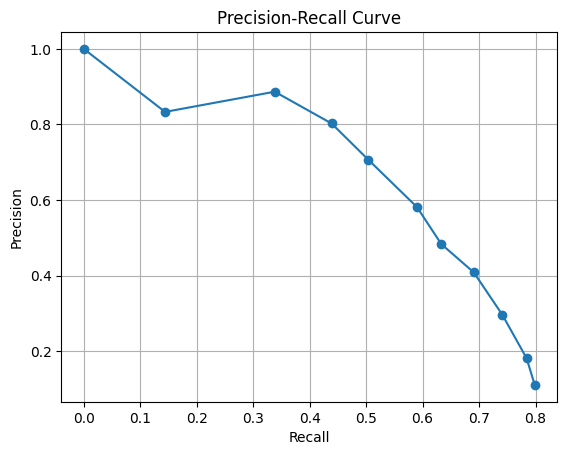

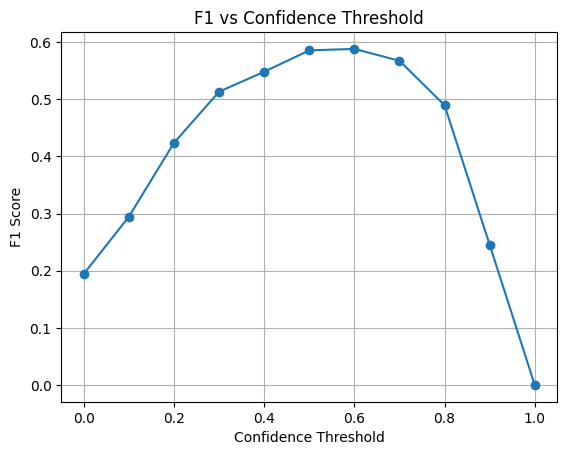

In [ ]:
thresholds = np.linspace(0.0, 1.0, 11)
threshold_analysis(
    model,
    threshold_name="confidence",
    thresholds=thresholds,
)

### IoU threshold


Threshold Analysis: 100%|██████████| 11/11 [31:26<00:00, 171.52s/it]


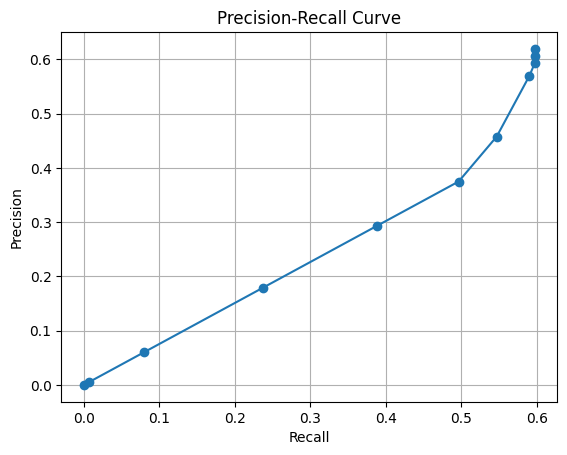

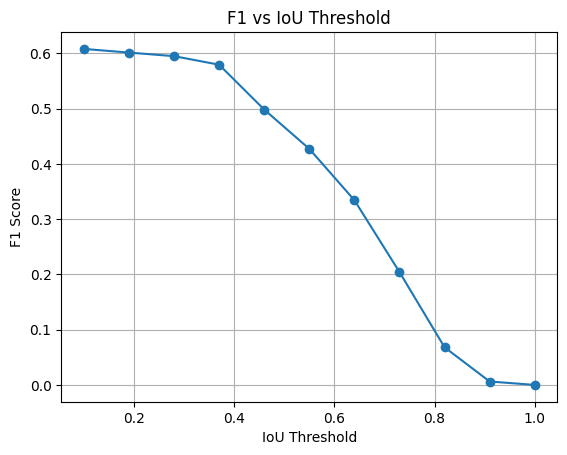

In [ ]:
ious = np.linspace(0.1, 1, 11)
threshold_analysis(
    model,
    threshold_name="iou",
    thresholds=ious,
)

The precision-recall curve does not look like a usual PR curve.
Some of our ideas on why this happened:

At very low IoU thresholds, the model’s loose and inaccurate predictions are counted as correct, leading to many false positives and missed detections, resulting in low precision and recall.
As the IoU threshold increases, only better-aligned predictions are considered, filtering out poor matches.
Since the model produces moderately accurate bounding boxes, both precision and recall improve together, causing the curve to rise from (0,0) toward higher values.

### Final Evaluation

Evaluate the model at selected thresholds (confidence = 0.5, IoU = 0.2) and print the final key metrics:

- **Precision**
- **Recall**
- **F1 Score**


In [30]:
tp, fp, fn, _, __ = evaluate_model(
    model,
    datamodule.val_dataloader(),
    confidence_threshold=0.5,
    iou_threshold=0.2,
)

r = recall(tp, fn)
p = precision(tp, fp)
f1 = f1_score(tp, fp, fn)
print(f"Recall: {r:.4f}")
print(f"Precision: {p:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating: 100%|██████████| 25/25 [02:44<00:00,  6.57s/it]

True Positives: 83
False Positives: 54
False Negatives: 56
Mean IoU: 0.2738
Mean IoU (TP): 0.6367
Recall: 0.5971
Precision: 0.6058
F1 Score: 0.6014


## Summary

#### Performance Metrics

The evaluation of our detection model is based on the previously described metrics, offering a comprehensive view of its ability to accurately detect mass tumors.

- **Precision**: 0.6058  
   The precision score indicates that approximately 60.6% of the model's predicted masses were correct detections, suggesting a moderate rate of false positives.

- **Recall**: 0.5971  
   The recall score shows that the model successfully detected about 59.7% of the actual masses, highlighting that while many tumors were found, some were missed.

- **F1 Score**: 0.6014  
   The F1 score, as the harmonic mean of precision and recall, reflects a moderately balanced performance between detecting true masses and minimizing incorrect detections.

- **Mean IoU (All Cases)**: 0.2738  
   The mean IoU across all cases (assigning 0 for missed detections) provides a realistic overall measure of the model’s localization accuracy, accounting for both successful and failed detections.

- **Mean IoU (True Positives)**: 0.6367  
   When considering only the correctly detected tumors, the mean IoU of 0.6367 shows that the model achieves reasonably good overlap between predictions and ground truth.

#### Conclusion

The model shows acceptable detection capabilities, with a moderate balance between precision and recall, and decent localization accuracy when detections are correct.  
While the performance is not perfect, it is a strong baseline and shows promising potential, especially considering the difficulty of the task.  
Further improvements — such as more data, refined threshold tuning, and model enhancements — could strengthen its performance.  
Nonetheless, medical expert validation remains critical before any real-world application.